# LendingClub Project

## Problem
Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), build a model that can predict wether or nor a borrower will pay back their loan. This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. 

The "loan_status" column contains our label.

## Data Overview

In [1]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# display plots in line
%matplotlib inline
# for faster tab autocomplete usage
%config Completer.use_jedi = False

# set global styling
sns.set_style('whitegrid')
sns.set_palette('YlGnBu_r', 3)

# load in a df of features as index and descriptions
data_info = pd.read_csv('lending_club_info.csv', index_col='LoanStatNew')

print('Feature Description List:')
data_info

Feature Description List:


,Description
LoanStatNew,
loan_amnt,The listed amount of the loan applied for by t...
term,The number of payments on the loan. Values are...
int_rate,Interest Rate on the loan
installment,The monthly payment owed by the borrower if th...
grade,LC assigned loan grade
sub_grade,LC assigned loan subgrade
emp_title,The job title supplied by the Borrower when ap...
emp_length,Employment length in years. Possible values ar...
home_ownership,The home ownership status provided by the borr...


In [2]:
# define function to return the description given a feature name
def feat_info(feat_name):
    """
    Return description given feature name.
    """
    print(feat_name,': ', data_info.loc[feat_name]['Description'])

In [3]:
# load in working data
loan_data = pd.read_csv('lending_club_loan_two.csv')
loan_data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [4]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

Note that there is missing data that will have to be dealt with.

## Exploratory Data Analysis

Text(0.5, 1.0, 'Loan Status Count')

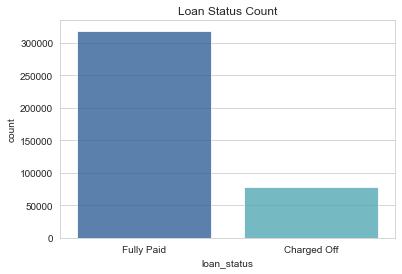

In [5]:
sns.countplot(data=loan_data, x='loan_status', alpha=0.8)
plt.title('Loan Status Count')

The majority of the loans are fully paid off but there is still a decent amount (approx 25%) that were charged/written off. Overall the data is imbalanced towards fully paid loans.

Text(0.5, 1.0, 'Distribution of Loan Amount')

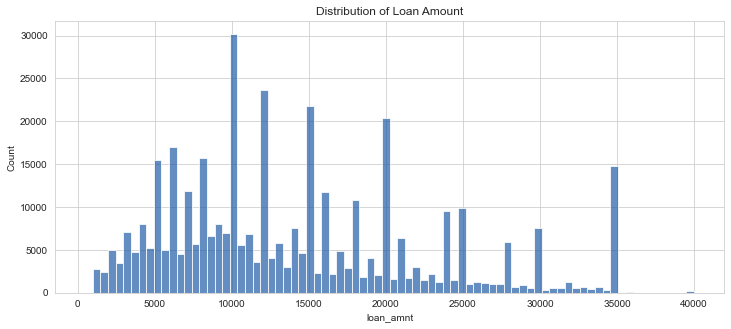

In [6]:
plt.figure(figsize=(12,5))
sns.histplot(data=loan_data, x='loan_amnt', bins=80, alpha=0.7)
plt.title('Distribution of Loan Amount')

The majority of the loan amounts fall around 10k. There are spikes at amounts divisible be 5k which would make sense as you would useually request an even loan amount. There looks to be one large amount at 40k.

In [7]:
loan_data.corr()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035


Text(0.5, 1.0, 'Feature Correlations')

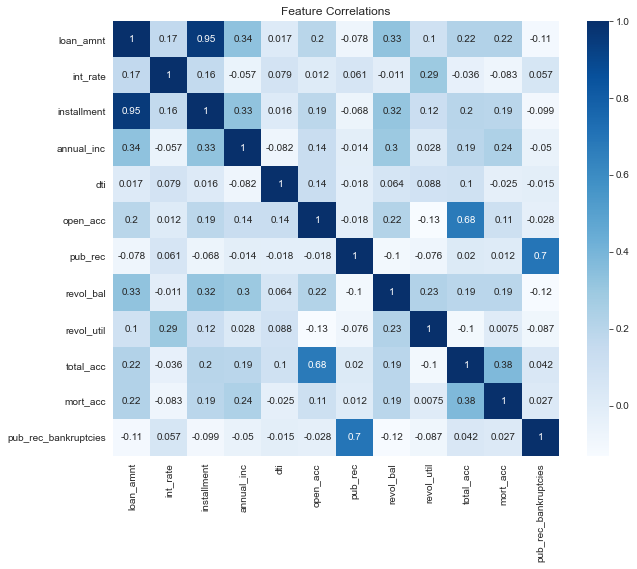

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(loan_data.corr(), cmap='Blues', annot=True)
plt.title('Feature Correlations')

In [9]:
feat_info('installment')
feat_info('total_acc')
feat_info('open_acc')
feat_info('pub_rec')
feat_info('pub_rec_bankruptcies')

installment :  The monthly payment owed by the borrower if the loan originates.
total_acc :  The total number of credit lines currently in the borrower's credit file
open_acc :  The number of open credit lines in the borrower's credit file.
pub_rec :  Number of derogatory public records
pub_rec_bankruptcies :  Number of public record bankruptcies


There seems to be near perfect correlation between loan_amnt and installment. This would make sense as the installment amount is dependent on how much the loan is. Since these features are so highly correlated, one of the features should be removed from the model.    
There is also high correlation between:    
total_acc and open_acc    
pub_rec_bankruptcies and pub_rec

Text(0.5, 1.0, 'Loan Amount vs Installment')

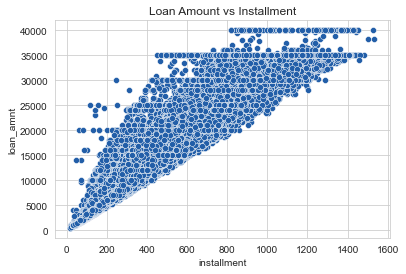

In [10]:
sns.scatterplot(data=loan_data, x='installment', y='loan_amnt')
plt.title('Loan Amount vs Installment')

As the loan amount increases, the range of installments also increases with the overall trend of greater installments. The larger range is probably dependent on the term of the policy as well. A longer term for a loan would result in lower installments.

Text(0.5, 1.0, 'Loan Amount by Loan Status')

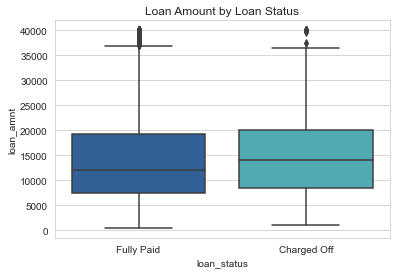

In [11]:
sns.boxplot(data=loan_data, x='loan_status', y='loan_amnt')
plt.title('Loan Amount by Loan Status')

There is similar distribution of loan amounts between fully paid and charged off loans. Charged off loans are slightly higher in loan amounts.

In [12]:
print('Statistics by Loan Status:')
loan_data.groupby('loan_status')['loan_amnt'].describe()

Statistics by Loan Status:


,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


I'll now analyze the grade and sub_grade features.

In [13]:
feat_info('grade')
feat_info('sub_grade')

grade :  LC assigned loan grade
sub_grade :  LC assigned loan subgrade


In [14]:
# unique grade values
loan_data['grade'].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [15]:
# unique sub_grade values
loan_data['sub_grade'].unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

In [16]:
# sort unique values
grade_order = sorted(loan_data['grade'].unique())
subgrade_order = sorted(loan_data['sub_grade'].unique())

Text(0.5, 1.0, 'Count of Grade by Loan Status')

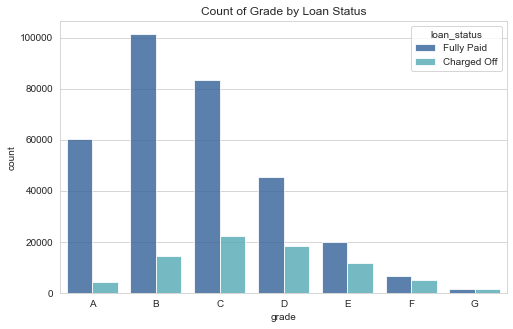

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(data=loan_data, x='grade', hue='loan_status', order=grade_order, alpha=0.8)
plt.title('Count of Grade by Loan Status')

As the grade gets lower, the proportion of charged off loans to fully paid loans increases. As grade is likely a measure of risk, this would make sense that the lower a grade a borrower has, the less likely they are to repay their loan in full.

Text(0.5, 1.0, 'Count of Sub Grades')

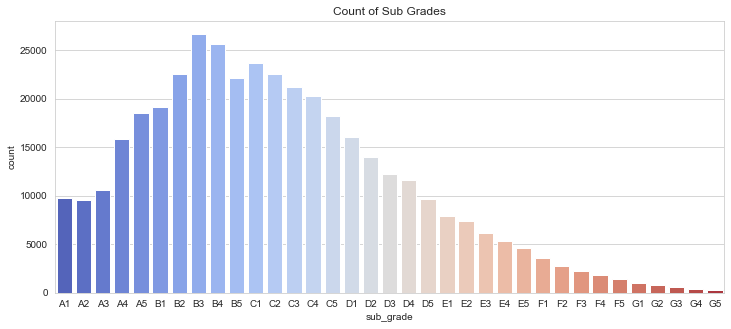

In [18]:
plt.figure(figsize=(12,5))
sns.countplot(data=loan_data, x='sub_grade', order=subgrade_order, palette='coolwarm')
plt.title('Count of Sub Grades')

Most grades fall in the B range.

Text(0.5, 1.0, 'Count of Sub Grades by Loan Status')

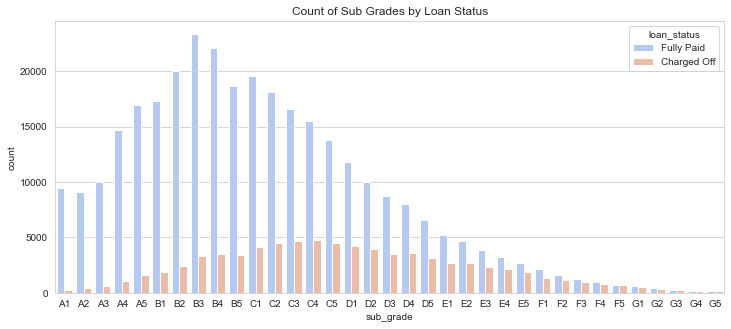

In [19]:
plt.figure(figsize=(12,5))
sns.countplot(data=loan_data, x='sub_grade', order=subgrade_order, 
              palette='coolwarm', hue='loan_status')
plt.title('Count of Sub Grades by Loan Status')

It looks like the proportion of F and G subgrades proportionally do not get paid back as often as the higher sub grades as mentioned before so I'll take a closer look into these loans.

Text(0.5, 1.0, 'Count of Low Sub Grades by Loan Status')

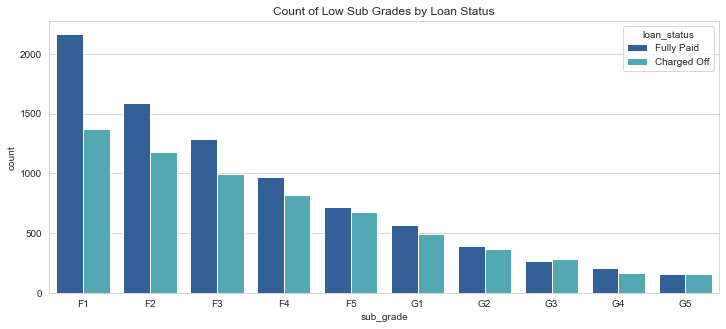

In [20]:
# define low_grades df as F and G grades
low_grades = loan_data[(loan_data['grade'] == 'F') | (loan_data['grade'] == 'G')]
# sort the low grades data
subgrade_order = sorted(low_grades['sub_grade'].unique())

plt.figure(figsize=(12,5))
sns.countplot(data=low_grades, x='sub_grade', order=subgrade_order, 
              hue='loan_status')
plt.title('Count of Low Sub Grades by Loan Status')

In [21]:
def loan_repaid(loan_status):
    """
    Return boolean value for Fully Paid given loan_status.
    """    
    if loan_status == 'Fully Paid':
        return 1
    else:
        return 0

loan_data['loan_repaid'] = loan_data['loan_status'].apply(loan_repaid)

Text(0, 0.5, 'Correlation')

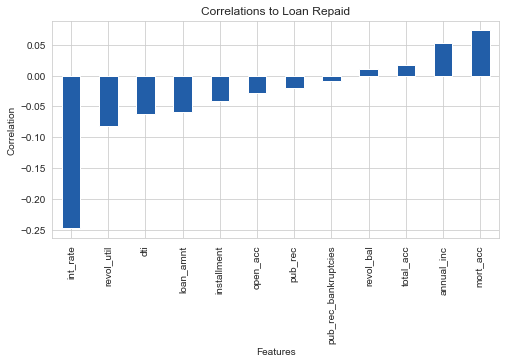

In [22]:
plt.figure(figsize=(8,4))
loan_data.corr()['loan_repaid'].sort_values().drop('loan_repaid').plot(kind='bar')
plt.title('Correlations to Loan Repaid')
plt.xlabel('Features')
plt.ylabel('Correlation')

The highest absolute correlation to loan repaid is int_rate. Interest rate is inversely correlated to if a loan was repaid or not. 

## Data Preprocessing
### Missing Data
Look at each column with missing data and decide on whether to remove the feature from the model or replace the missing data.

In [23]:
print('rows, columns = ', loan_data.shape)

rows, columns =  (396030, 28)


In [24]:
print('Count of Null Values:')
loan_data.isnull().sum().sort_values(ascending=False)

Count of Null Values:


mort_acc                37795
emp_title               22927
emp_length              18301
title                    1755
pub_rec_bankruptcies      535
revol_util                276
dti                         0
address                     0
application_type            0
initial_list_status         0
total_acc                   0
revol_bal                   0
pub_rec                     0
open_acc                    0
earliest_cr_line            0
loan_amnt                   0
term                        0
purpose                     0
loan_status                 0
issue_d                     0
verification_status         0
annual_inc                  0
home_ownership              0
sub_grade                   0
grade                       0
installment                 0
int_rate                    0
loan_repaid                 0
dtype: int64

In [25]:
print('Percentage of Null Values:')
loan_data.isnull().sum().sort_values(ascending=False)/len(loan_data)*100

Percentage of Null Values:


mort_acc                9.543469
emp_title               5.789208
emp_length              4.621115
title                   0.443148
pub_rec_bankruptcies    0.135091
revol_util              0.069692
dti                     0.000000
address                 0.000000
application_type        0.000000
initial_list_status     0.000000
total_acc               0.000000
revol_bal               0.000000
pub_rec                 0.000000
open_acc                0.000000
earliest_cr_line        0.000000
loan_amnt               0.000000
term                    0.000000
purpose                 0.000000
loan_status             0.000000
issue_d                 0.000000
verification_status     0.000000
annual_inc              0.000000
home_ownership          0.000000
sub_grade               0.000000
grade                   0.000000
installment             0.000000
int_rate                0.000000
loan_repaid             0.000000
dtype: float64

#### emp_title

In [26]:
feat_info('emp_title')

emp_title :  The job title supplied by the Borrower when applying for the loan.*


In [27]:
print('Number of missing data points: ', loan_data['emp_title'].isnull().sum())

Number of missing data points:  22927


In [28]:
print('Count of Unique Titles: ', loan_data['emp_title'].nunique())

Count of Unique Titles:  173105


In [29]:
print('Count of Each Title:')
loan_data['emp_title'].value_counts()

Count of Each Title:


Teacher                           4389
Manager                           4250
Registered Nurse                  1856
RN                                1846
Supervisor                        1830
                                  ... 
Culinary Arts Teacher                1
Yrc freight                          1
registered nnurse                    1
Elevator Texhnician                  1
San Gorgonio Memorial Hospital       1
Name: emp_title, Length: 173105, dtype: int64

Since there are too many different job titles as well as missing ones, I will remove this feature.

In [30]:
# remove emp_title column
loan_data = loan_data.drop('emp_title', axis=1)

#### emp_length

In [31]:
feat_info('emp_length')

emp_length :  Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


In [32]:
print('Number of missing data points: ', loan_data['emp_length'].isnull().sum())

Number of missing data points:  18301


In [33]:
print('Employee Length Categories:')
loan_data['emp_length'].unique()

Employee Length Categories:


array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [34]:
# order the emp length column to ascending
emp_length_order = [ '< 1 year',
                      '1 year',
                     '2 years',
                     '3 years',
                     '4 years',
                     '5 years',
                     '6 years',
                     '7 years',
                     '8 years',
                     '9 years',
                     '10+ years']

Text(0.5, 1.0, 'Count of Employment Length by Loan Status')

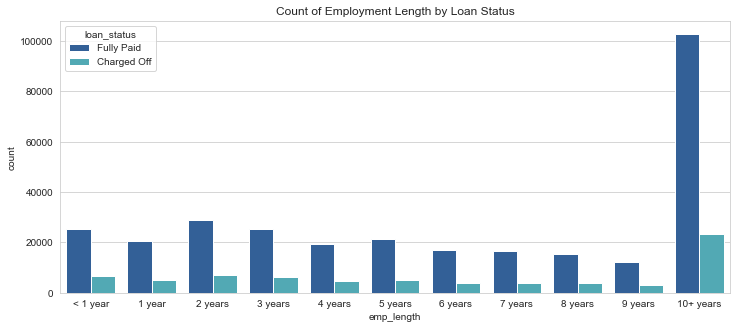

In [35]:
plt.figure(figsize=(12,5))
sns.countplot(data=loan_data, x='emp_length', hue='loan_status',
             order=emp_length_order)
plt.title('Count of Employment Length by Loan Status')

The proportion of Charged Off to Fully Paid does not really seem to differ between a borrower's employment length. Given this and the fact that 4.6% of the data is missing, let's drop the feature.

In [36]:
# remove emp_length column
loan_data = loan_data.drop('emp_length', axis=1)

#### title
There seems to be some similarities between the title and purpose columns so I will analyze to see if there is any relationship.

In [37]:
feat_info('title')
feat_info('purpose')

title :  The loan title provided by the borrower
purpose :  A category provided by the borrower for the loan request. 


In [38]:
print('Number of missing data points: ', loan_data['title'].isnull().sum())

Number of missing data points:  1755


In [39]:
loan_data['title']

0                        Vacation
1              Debt consolidation
2         Credit card refinancing
3         Credit card refinancing
4           Credit Card Refinance
                   ...           
396025         Debt consolidation
396026         Debt consolidation
396027       pay off credit cards
396028              Loanforpayoff
396029          Toxic Debt Payoff
Name: title, Length: 396030, dtype: object

In [40]:
loan_data['purpose']

0                   vacation
1         debt_consolidation
2                credit_card
3                credit_card
4                credit_card
                 ...        
396025    debt_consolidation
396026    debt_consolidation
396027    debt_consolidation
396028    debt_consolidation
396029    debt_consolidation
Name: purpose, Length: 396030, dtype: object

The title column is just a description of the purpose column so it can be removed.

In [41]:
# remove title column
loan_data = loan_data.drop('title', axis=1)

#### mort_acc

In [42]:
feat_info('mort_acc')

mort_acc :  Number of mortgage accounts.


In [43]:
print('Number of missing data points: ', loan_data['mort_acc'].isnull().sum())

Number of missing data points:  37795


In [44]:
print('Distribution of Number of Mortgage Accounts:')
loan_data['mort_acc'].value_counts(ascending=False)

Distribution of Number of Mortgage Accounts:


0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
23.0         2
31.0         2
26.0         2
32.0         2
28.0         1
34.0         1
30.0         1
Name: mort_acc, dtype: int64

In [45]:
print('Correlations to mort_acc:')
loan_data.corr()['mort_acc'].sort_values()

Correlations to mort_acc:


int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

In [46]:
feat_info('total_acc')

total_acc :  The total number of credit lines currently in the borrower's credit file


total_acc correlates the most with mort_acc which would make sense given the count of mortgage accounts would be counted in the total number of credit lines a borrower has.    

I will fill the missing mort_acc with the mean of the mort_acc by total_acc.

In [47]:
# mean of mort_acc by total_acc
total_acc_mort_avg = loan_data.groupby('total_acc')['mort_acc'].mean()

def fill_mort_acc(total_acc, mort_acc):
    '''
    Returns the mort_acc avg of the given total_acc if mort_acc is null.
    '''
    if np.isnan(mort_acc):
        return total_acc_mort_avg[total_acc]
    else:
        return mort_acc
    
loan_data['mort_acc'] = loan_data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

#### revol_util & pub_rec

In [48]:
feat_info('revol_util')
feat_info('pub_rec_bankruptcies')

revol_util :  Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
pub_rec_bankruptcies :  Number of public record bankruptcies


In [49]:
print('Number of missing revol_util data points: ', loan_data['revol_util'].isnull().sum())
print('Number of missing pub_rec_bankruptcies data points: ', loan_data['pub_rec'].isnull().sum())

Number of missing revol_util data points:  276
Number of missing pub_rec_bankruptcies data points:  0


Since these last two account for less than 0.5% of the data, I will just drop the rows with missing data.

In [50]:
# drop all rows with missing data
loan_data = loan_data.dropna()

### Categorical Variables
Review all categorical columns and decide whether to remove them from the model or convert them to dummy variables.

In [51]:
print('Categorical Variables:')
# select all object type columns
loan_data.select_dtypes(['object']).columns

Categorical Variables:


Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

#### term 

In [52]:
feat_info('term')

term :  The number of payments on the loan. Values are in months and can be either 36 or 60.


I'll convert the term column into two integers: 36 or 60.

In [53]:
# take the first 2 characters and convert to an integer
loan_data.loc[:, 'term'] = loan_data['term'].apply(lambda term: int(term[:3]))

#### grade
During the exploratory data analysis section it was identified that grade is a less descriptive column than sub_grade so I'll remove grade.

In [54]:
# remove grade column
loan_data = loan_data.drop('grade',axis=1)

#### sub_grade
Convert to dummy variables.

In [55]:
# create dummy variables
subgrade_dummies = pd.get_dummies(loan_data['sub_grade'], drop_first=True)
# drop sub_grade column
loan_data = loan_data.drop('sub_grade', axis=1)
# concatenate dummy variables to data
loan_data = pd.concat([loan_data, subgrade_dummies], axis=1)

#### verification_status, application_type, initial_list_status, purpose 
These will all be converted to dummy variables.

In [56]:
feat_info('verification_status')
feat_info('application_type')
feat_info('initial_list_status')
feat_info('purpose')

verification_status :  Indicates if income was verified by LC, not verified, or if the income source was verified
application_type :  Indicates whether the loan is an individual application or a joint application with two co-borrowers
initial_list_status :  The initial listing status of the loan. Possible values are – W, F
purpose :  A category provided by the borrower for the loan request. 


In [57]:
# create dummy variables
dummies = pd.get_dummies(loan_data[['verification_status', 'application_type',
                                    'initial_list_status','purpose']], drop_first=True)
# drop original columns
loan_data = loan_data.drop(['verification_status', 'application_type',
                            'initial_list_status', 'purpose'], axis=1)
# concatenate dummy variables to data
loan_data = pd.concat([loan_data,dummies], axis=1)

#### home_ownership
Convert to dummy variables.

In [58]:
loan_data['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

The none and any values do not give any unique information so I will convert them to the already existing OTHER category.

In [59]:
# replace NONE and ANY to OTHER
loan_data['home_ownership'] = loan_data['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')
# get dummy variables
dummies = pd.get_dummies(loan_data['home_ownership'], drop_first=True)
# drop home ownership column and concatenate with dummies
loan_data = pd.concat([loan_data.drop('home_ownership', axis=1), dummies], axis=1)

#### address
Use feature engineering to pull out zip code. Convert new zip code column to dummy variables and drop the original address column.

In [60]:
loan_data['address'].head()

0       0174 Michelle Gateway\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113
3              823 Reid Ford\nDelacruzside, MA 00813
4               679 Luna Roads\nGreggshire, VA 11650
Name: address, dtype: object

The format of the address has the zip code as the last five characters of the string. State could also be a relevant feature but I will go with zip code as it has more specific info.

In [61]:
# create new zip code column by pulling out the last 5 characters from the address column
loan_data['zip_code'] = loan_data['address'].apply(lambda address: address[-5:])
# create dummy variables
dummies = pd.get_dummies(loan_data['zip_code'], drop_first=True)
# drop zip code and address columns
loan_data = loan_data.drop(['zip_code', 'address'], axis=1)
# concatenate dummy variables to data
loan_data = pd.concat([loan_data, dummies], axis=1)

#### issue_d

In [62]:
feat_info('issue_d')

issue_d :  The month which the loan was funded


We wouldn't know beforehand whether or not a loan would be issued so we would not have this feature. We'll remove it or else this would be data leakage.

In [63]:
# drop issue_d column
loan_data = loan_data.drop('issue_d', axis=1)

#### earliest_cr_line

In [64]:
feat_info('earliest_cr_line')

earliest_cr_line :  The month the borrower's earliest reported credit line was opened


In [65]:
loan_data['earliest_cr_line'].head()

0    Jun-1990
1    Jul-2004
2    Aug-2007
3    Sep-2006
4    Mar-1999
Name: earliest_cr_line, dtype: object

In [66]:
# create a year column based on last four characters
loan_data['earliest_cr_line'] = loan_data['earliest_cr_line'].apply(lambda date: int(date[-4:]))

## Model Training

In [67]:
# drop loan_status column as we have already converted it to loan_repaid
loan_data = loan_data.drop('loan_status',axis=1)

# indicate feature and label columns in numpy array format
X = loan_data.drop('loan_repaid',axis=1).values
y = loan_data['loan_repaid'].values

# perform train-test split with test size 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Normalizing the Data
Normalize data using MinMaxScaler. Fit the data on X_train only to avoid data leakage and then transform on both X_train and y_train.

In [68]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Creating the Model

In [69]:
print('rows, columns: ', X_train.shape)

rows, columns:  (316175, 78)


In [70]:
# set early stop, patience: wait 5 epochs after
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# instantiate sequential model
model = Sequential([
    Dense(78, activation='relu'),
    Dropout(0.2),
    Dense(30, activation='relu'),
    Dropout(0.2),
    Dense(19, activation='relu'),
    Dropout(0.2),
    Dense(units=1,activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

# fit model to training data
model.fit(X_train, y_train, epochs=100, batch_size=300,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/100
1054/1054 [==============================] - 3s 3ms/step - loss: 0.3671 - val_loss: 0.2641
Epoch 2/100
1054/1054 [==============================] - 2s 2ms/step - loss: 0.2655 - val_loss: 0.2633
Epoch 3/100
1054/1054 [==============================] - 2s 2ms/step - loss: 0.2623 - val_loss: 0.2624
Epoch 4/100
1054/1054 [==============================] - 2s 2ms/step - loss: 0.2614 - val_loss: 0.2619
Epoch 5/100
1054/1054 [==============================] - 2s 2ms/step - loss: 0.2603 - val_loss: 0.2619
Epoch 6/100
1054/1054 [==============================] - 2s 2ms/step - loss: 0.2617 - val_loss: 0.2613
Epoch 7/100
1054/1054 [==============================] - 2s 2ms/step - loss: 0.2600 - val_loss: 0.2616
Epoch 8/100
1054/1054 [==============================] - 2s 2ms/step - loss: 0.2598 - val_loss: 0.2616
Epoch 9/100
1054/1054 [==============================] - 2s 2ms/step - loss: 0.2595 - val_loss: 0.2610
Epoch 10/100
1054/1054 [==============================] - 2s 2ms/step - l

## Model Evaluation

Text(0, 0.5, 'Loss')

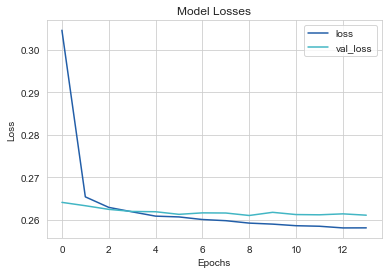

In [71]:
# create losses df from model histroy
losses = pd.DataFrame(model.history.history)

# plot losses between the train and test data
losses[['loss','val_loss']].plot()
plt.title('Model Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')

The test data's loss evens out around 15-25 epochs so we will leave the model selection as is.

In [72]:
# predict whether the loan is repaid on the test data
predictions = (model.predict(X_test) > 0.5).astype("int32")

In [73]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.44      0.61     15658
           1       0.88      1.00      0.93     63386

    accuracy                           0.89     79044
   macro avg       0.93      0.72      0.77     79044
weighted avg       0.90      0.89      0.87     79044



In [74]:
print(confusion_matrix(y_test, predictions))

[[ 6942  8716]
 [  176 63210]]


Text(0.5, 1.0, 'Confusion Matrix')

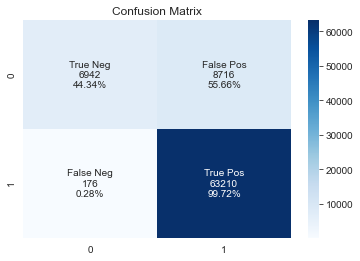

In [75]:
cnf_matrix = confusion_matrix(y_test, predictions)

# confusion matrix in percentages
cnf_percent = np.concatenate((cnf_matrix[0]/np.sum(cnf_matrix[0]), cnf_matrix[1]/np.sum(cnf_matrix[1])))

# set confusion matrix labels
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cnf_percent]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# create heatmap with labels
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix')

Given that this model is heavily imbalanced to fully paid loans (at 80%), the accuracy of 89% is okay. The precision for class 0, charged off loans is good but the recall is quite low meaning that only 44% of of true class 0's were correctly classified.

The purpose of using such a model would be to avoid loaning to borrowers that are not likely to pay back their loans in full so the importance of predicting class 0 correctly is high. Based off of this, I would say that these aren't the best metrics for that.